In [23]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn


In [24]:
import mlflow
mlflow.set_experiment("LendSecure_Model_Experiment")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
print("Tracking URI:",mlflow.get_tracking_uri())



Traceback (most recent call last):
  File "C:\Users\Jones Mbela\AppData\Roaming\Python\Python312\site-packages\mlflow\store\tracking\file_store.py", line 379, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jones Mbela\AppData\Roaming\Python\Python312\site-packages\mlflow\store\tracking\file_store.py", line 477, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jones Mbela\AppData\Roaming\Python\Python312\site-packages\mlflow\store\tracking\file_store.py", line 1662, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jones Mbela\AppData\Roaming\Python\Python312\site-packages\mlflow\store\tracking\file_store.py", line 1655, in _read_helper


Tracking URI: http://127.0.0.1:5000/


In [26]:
#Defininng X and y
df = pd.read_csv("C:\\Users\\Jones Mbela\\Desktop\\RENNY\\AI AND ML\\Lend Secure\\Data\\featured_engineered_real_estate_data.csv")
X = df.drop(columns=["price_in_USD"])
y = np.log1p(df["price_in_USD"])

In [4]:
#Train/Validation/Test Split
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.3,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)


In [27]:
#Baseline model(mean predictor)
baseline_pred=np.full_like(y_val, y_train.mean())
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_rmse = root_mean_squared_error(y_val, baseline_pred)
baseline_r2 = r2_score(y_val, baseline_pred)

print(f"Baseline MAE: {baseline_mae}")
print(f"Baseline RMSE: {baseline_rmse}") 
print(f"Baseline R2: {baseline_r2}")

Baseline MAE: 0.8499286916842116
Baseline RMSE: 1.1017068872906497
Baseline R2: -0.0002968236900657839


In [28]:
#Define candidate models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    )
}

In [29]:
#Cross validation setup
cv= KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2"
}

In [30]:
#Model comparison loop
results = []
for name,model in models.items():
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    results.append({
        "Model": name,
        "MAE":-cv_results["test_MAE"].mean(),
        "RMSE":-cv_results["test_RMSE"].mean(),
        "R2":-cv_results["test_R2"].mean()
    })
results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,Model,MAE,RMSE,R2
5,Random Forest,0.339257,0.498677,-0.794195
4,Decision Tree,0.410602,0.621024,-0.680833
0,Linear Regression,0.458142,0.627016,-0.674622
1,Ridge Regression,0.458049,0.627032,-0.674605
3,ElasticNet Regression,0.460707,0.630858,-0.670623
2,Lasso Regression,0.461829,0.632245,-0.669172


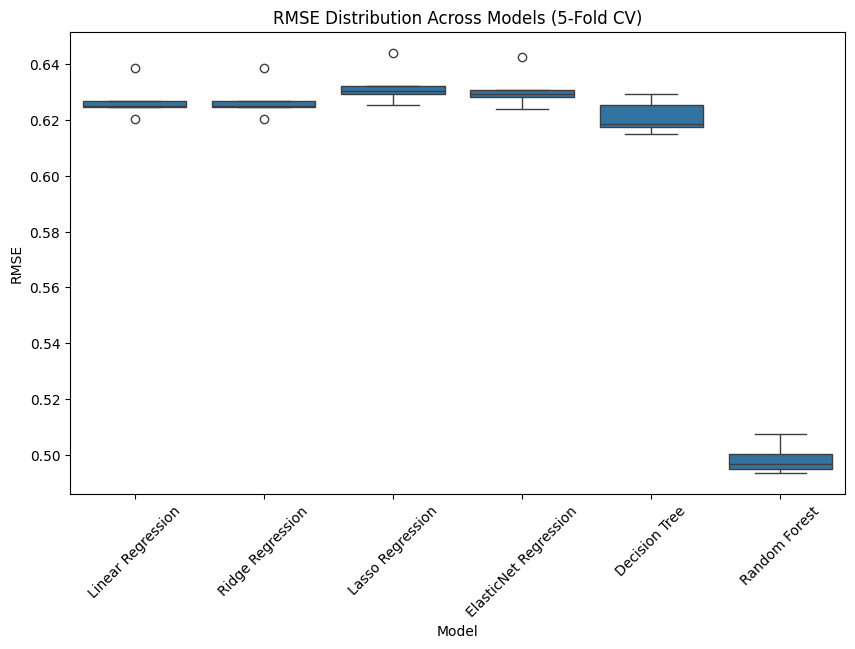

In [9]:
#Box plots
import matplotlib.pyplot as plt
import seaborn as sns
cv_results_list = []
for name,model in models.items():
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        
    )
    for i in range(len(cv_results["test_RMSE"])):
        cv_results_list.append({
            "Model": name,
            "RMSE": -cv_results["test_RMSE"][i]
        })
cv_df = pd.DataFrame(cv_results_list)
plt.figure(figsize=(10,6))
sns.boxplot(x="Model", y="RMSE", data=cv_df)
plt.xticks(rotation=45)
plt.title("RMSE Distribution Across Models (5-Fold CV)")
plt.show()

In [31]:
#Train the best model on the full training set and evaluate on the test set
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
with mlflow.start_run(run_name="RandomForest_LendSecure"):
    best_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)
    val_predictions = best_model.predict(X_val)

    rmse=root_mean_squared_error(y_val, val_predictions)
    mae=mean_absolute_error(y_val, val_predictions)
    r2=r2_score(y_val, val_predictions)
   
    # Log metrics to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    #log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 300)

    # Log the model
    mlflow.sklearn.log_model(sk_model=best_model,name="model",registered_model_name="LendSecure_Randomforest_Model")
  



2026/01/20 14:51:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JONESM~1\AppData\Local\Temp\tmp9eslve94\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'LendSecure_Randomforest_Model'.
2026/01/20 14:56:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LendSecure_Randomforest_Model, version 1
Created version '1' of model 'LendSecure_Randomforest_Model'.


🏃 View run RandomForest_LendSecure at: http://127.0.0.1:5000/#/experiments/734911405326892526/runs/7063ea093d034c35b5b454ed2bea1a6f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/734911405326892526


In [13]:
#Register the model
import mlflow
from mlflow.tracking import MlflowClient
RUN_ID= "28a9c5eb8f3b4dd89528b02c6342db18"
MODEL_NAME= "LendSecure_RF_Model"
client= MlflowClient()
result= mlflow.register_model(f"runs:/{RUN_ID}/model", name=MODEL_NAME)
print("Registered Model:",result.version)

C:\Users\Jones Mbela\AppData\Roaming\Python\Python312\site-packages\mlflow\tracking\_model_registry\utils.py:216: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri)
Successfully registered model 'LendSecure_RF_Model'.
2026/01/18 19:02:47 WARNING mlflow.tracking._model_registry.fluent: Run with id 28a9c5eb8f3b4dd89528b02c6342db18 has no artifacts at artifact path 'model', registering model based on models:/m-216c44bec47e495e8f285b3603060b5e instead


Registered Model: 1


Created version '1' of model 'LendSecure_RF_Model'.


In [34]:
#Assigning Alias
from mlflow.tracking import MlflowClient
client= MlflowClient(tracking_uri="http://127.0.0.1:5000")
models= client.search_registered_models()  
models


[<RegisteredModel: aliases={'Production': '1'}, creation_timestamp=1768752167061, deployment_job_id='', deployment_job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', description='', last_updated_timestamp=1768802915453, latest_versions=[<ModelVersion: aliases=['Production'], creation_timestamp=1768752167556, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description=None, last_updated_timestamp=1768752167556, metrics=None, model_id=None, name='LendSecure_RF_Model', params=None, run_id='28a9c5eb8f3b4dd89528b02c6342db18', run_link='', source='models:/m-216c44bec47e495e8f285b3603060b5e', status='READY', status_message=None, tags={}, user_id='', version='1'>], name='LendSecure_RF_Model', tags={}>,
 <RegisteredModel: aliases={'production': '1'}, creation_timestamp=1768910162167, deployment_job_id='', deploy

In [ ]:
#Evaluating on the test set
test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = root_mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

test_mae, test_rmse, test_r2

(0.33156788899895884, 0.49278901532607744, 0.7945559088521448)

In [34]:
import joblib
joblib.dump(best_model,"C:\\Users\\Jones Mbela\\Desktop\\RENNY\\AI AND ML\\Lend Secure\\Models\\best_random_forest_model.pkl")

['C:\\Users\\Jones Mbela\\Desktop\\RENNY\\AI AND ML\\Lend Secure\\Models\\best_random_forest_model.pkl']